In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379373 sha256=ff705219d34d978bcf209d0914cceb1688730aff9fdc5df38b97179ea1d3d4ed
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

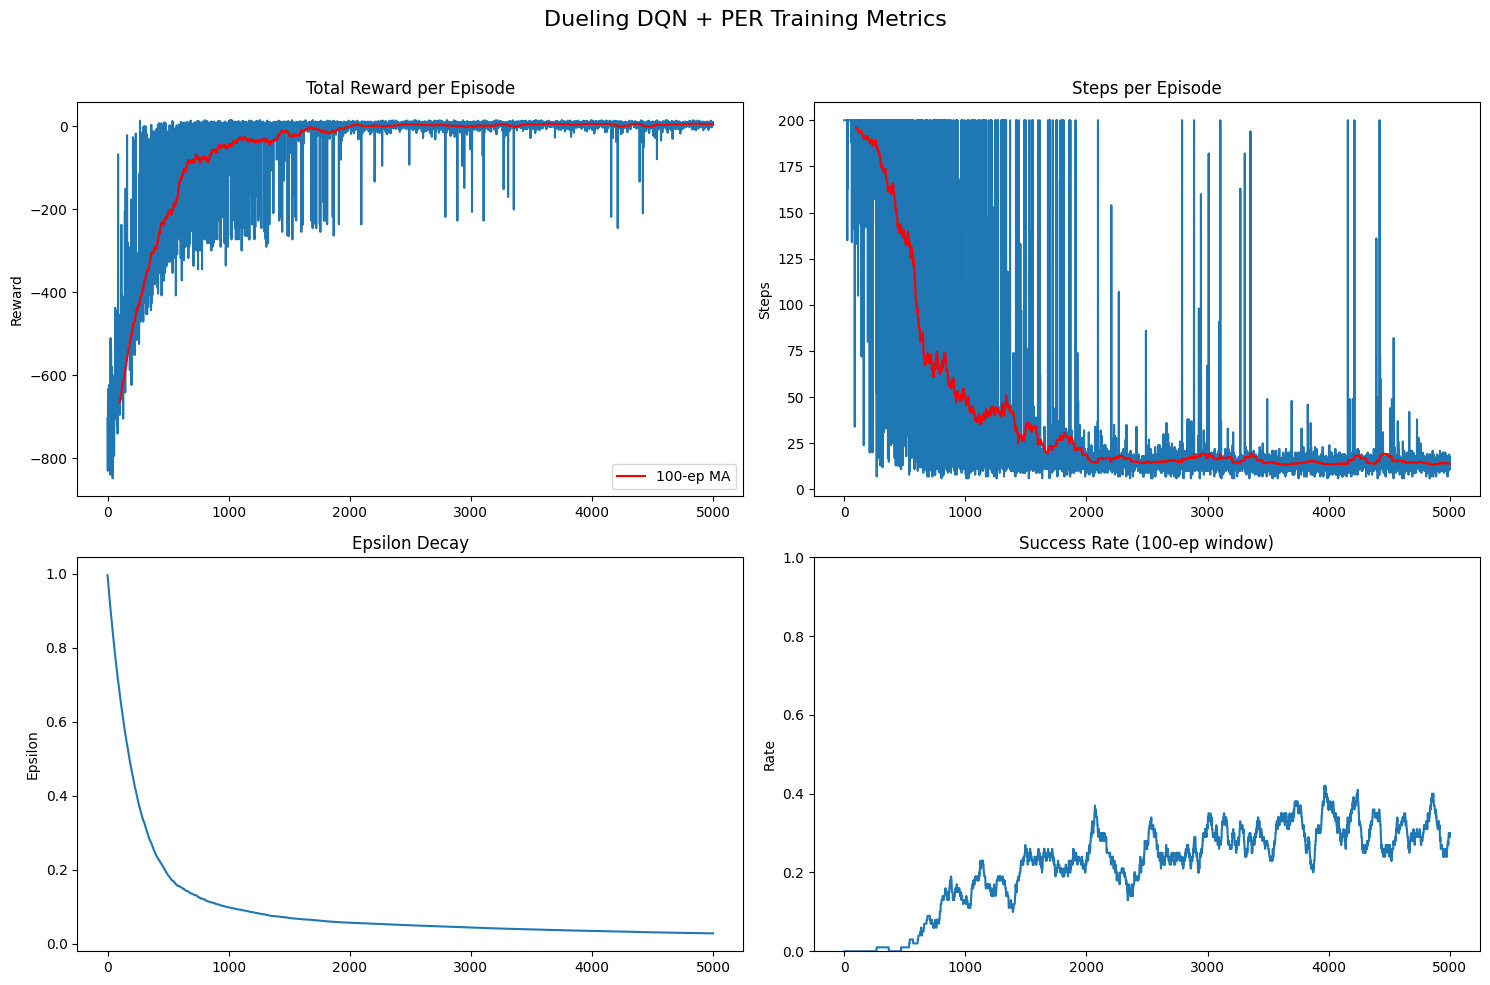

Evaluation over 1000 eps:
 Avg Reward: 7.05, Avg Steps: 13.9, Success Rate: 37.00%


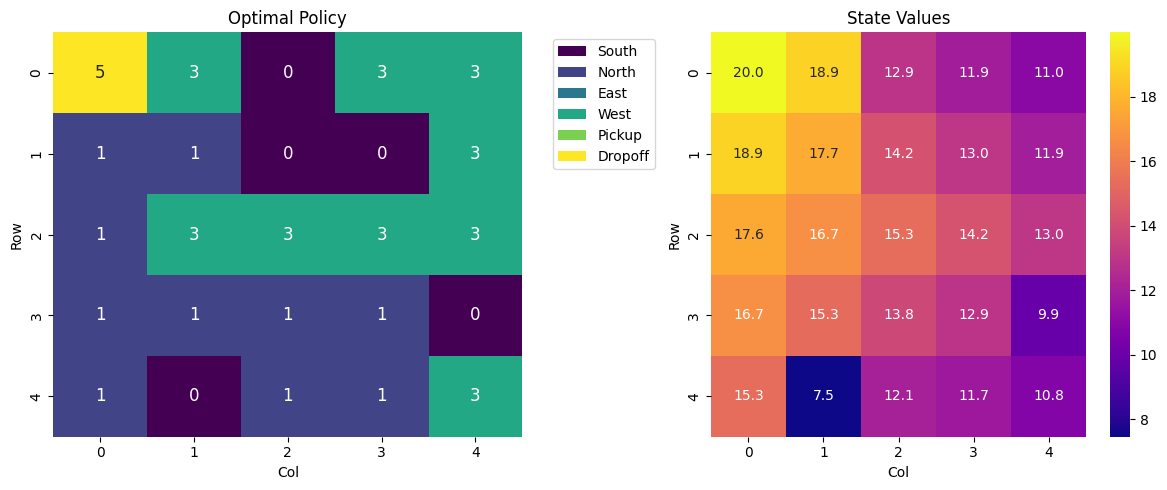

In [2]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from matplotlib.patches import Patch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment setup

env = gym.make('Taxi-v3')
STATE_DIM  = env.observation_space.n
ACTION_DIM = env.action_space.n


# Dueling DQN network
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.adv_stream = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, x):
        f = self.feature(x)
        v = self.value_stream(f)
        a = self.adv_stream(f)
        # combine value & advantage streams
        return v + (a - a.mean(dim=1, keepdim=True))


# Prioritized Replay Buffer
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha):
        self.capacity   = capacity
        self.alpha      = alpha
        self.buffer     = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.pos        = 0

    def push(self, s, a, r, s_next, done):
        max_prio = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append((s, a, r, s_next, done))
        else:
            self.buffer[self.pos] = (s, a, r, s_next, done)
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta):
        prios = self.priorities if len(self.buffer) == self.capacity else self.priorities[:self.pos]
        probs = prios ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = map(np.array, zip(*samples))
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        return states, actions, rewards, next_states, dones, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, prio in zip(indices, priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)


# Helper functions
def state_to_tensor(state):
    # one-hot encode discrete state
    return F.one_hot(torch.tensor(state, device=device), num_classes=STATE_DIM).float()

def get_epsilon(frame_idx, eps_start=1.0, eps_end=0.01, eps_decay=50000):
    return eps_end + (eps_start - eps_end) * np.exp(-1. * frame_idx / eps_decay)

def get_beta(frame_idx, beta_start=0.4, beta_frames=20000*200):
    return min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)


# Hyperparameters
BUFFER_SIZE        = 10000
BATCH_SIZE         = 64
GAMMA              = 0.99
LR                 = 5e-4
TARGET_UPDATE_FREQ = 5000    # frames
NUM_EPISODES       = 5000
MAX_STEPS          = 200
MAX_GRAD_NORM      = 1.0
EVAL_EPISODES      = 1000


# Networks, optimizer, replay buffer
policy_net = DuelingDQN(STATE_DIM, ACTION_DIM).to(device)
target_net = DuelingDQN(STATE_DIM, ACTION_DIM).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory    = PrioritizedReplayBuffer(BUFFER_SIZE, alpha=0.6)


# TD-loss computation
def compute_td_loss(batch):
    states, actions, rewards, next_states, dones, indices, weights = batch

    states      = torch.tensor(states,      dtype=torch.float32, device=device)
    next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
    actions     = torch.tensor(actions,     dtype=torch.int64,   device=device).unsqueeze(1)
    rewards     = torch.tensor(rewards,     dtype=torch.float32, device=device).unsqueeze(1)
    dones       = torch.tensor(dones,       dtype=torch.float32, device=device).unsqueeze(1)
    weights     = torch.tensor(weights,     dtype=torch.float32, device=device).unsqueeze(1)

    # current Q
    q_values = policy_net(states).gather(1, actions)
    # double DQN: use policy_net to select, target_net to evaluate
    next_actions = policy_net(next_states).argmax(dim=1, keepdim=True)
    next_q       = target_net(next_states).gather(1, next_actions).detach()
    target_q     = rewards + GAMMA * next_q * (1 - dones)

    # TD errors & loss
    td_errors = (target_q - q_values).abs().detach().cpu().numpy().squeeze()
    loss      = (weights * F.mse_loss(q_values, target_q, reduction='none')).mean()

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), MAX_GRAD_NORM)
    optimizer.step()

    return indices, td_errors, loss.item()


# Training loop
frame_idx        = 0
rewards_list     = []
steps_list       = []
epsilons_list    = []
success_rate     = []
successes_window = []
window_size      = 100

for episode in tqdm(range(1, NUM_EPISODES+1), desc="Training Progress"):
    state, _     = env.reset()
    state_vec    = state_to_tensor(state)
    total_reward = 0
    steps        = 0

    while steps < MAX_STEPS:
        eps = get_epsilon(frame_idx)
        if random.random() < eps:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = policy_net(state_vec.unsqueeze(0)).argmax(1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done       = terminated or truncated
        next_vec   = state_to_tensor(next_state)

        memory.push(state_vec.cpu().numpy(), action, reward, next_vec.cpu().numpy(), done)
        state_vec = next_vec
        total_reward += reward
        frame_idx  += 1
        steps      += 1

        if len(memory) >= BATCH_SIZE:
            beta = get_beta(frame_idx)
            batch = memory.sample(BATCH_SIZE, beta)
            idxs, td_errs, loss = compute_td_loss(batch)
            memory.update_priorities(idxs, td_errs + 1e-6)

        if frame_idx % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if done:
            break

    # record metrics
    rewards_list.append(total_reward)
    steps_list.append(steps)
    epsilons_list.append(eps)

    # success rate window
    successes_window.append(1 if total_reward >= 9 else 0)
    if len(successes_window) > window_size:
        successes_window.pop(0)
    success_rate.append(sum(successes_window) / len(successes_window))

# Plot results
def plot_training_results(rewards, steps, epsilons, success_rate):
    fig, axs = plt.subplots(2, 2, figsize=(15,10))
    fig.suptitle('Dueling DQN + PER Training Metrics', fontsize=16)

    # rewards
    axs[0,0].plot(rewards)
    axs[0,0].set_title('Total Reward per Episode')
    axs[0,0].set_ylabel('Reward')
    smooth = pd.Series(rewards).rolling(100).mean()
    axs[0,0].plot(smooth, 'r', label='100-ep MA')
    axs[0,0].legend()

    # steps
    axs[0,1].plot(steps)
    axs[0,1].set_title('Steps per Episode')
    axs[0,1].set_ylabel('Steps')
    smooth = pd.Series(steps).rolling(100).mean()
    axs[0,1].plot(smooth, 'r')

    # epsilon
    axs[1,0].plot(epsilons)
    axs[1,0].set_title('Epsilon Decay')
    axs[1,0].set_ylabel('Epsilon')

    # success rate
    axs[1,1].plot(success_rate)
    axs[1,1].set_title('Success Rate (100-ep window)')
    axs[1,1].set_ylabel('Rate')
    axs[1,1].set_ylim(0,1)

    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

plot_training_results(rewards_list, steps_list, epsilons_list, success_rate)


# Evaluation
def evaluate_agent(env, agent, episodes=EVAL_EPISODES, max_steps=MAX_STEPS):
    total_rewards = []
    total_steps   = []
    successes     = 0

    for _ in range(episodes):
        state, _  = env.reset()
        vec       = state_to_tensor(state)
        done = False
        ep_rew = 0
        ep_st  = 0

        while not done and ep_st < max_steps:
            with torch.no_grad():
                action = agent(vec.unsqueeze(0)).argmax(1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            vec  = state_to_tensor(next_state)
            ep_rew += reward
            ep_st  += 1

        total_rewards.append(ep_rew)
        total_steps.append(ep_st)
        if ep_rew >= 9:
            successes += 1

    avg_rew  = np.mean(total_rewards)
    avg_st   = np.mean(total_steps)
    succ_rt  = successes / episodes
    print(f"Evaluation over {episodes} eps:\n Avg Reward: {avg_rew:.2f}, Avg Steps: {avg_st:.1f}, Success Rate: {succ_rt:.2%}")

evaluate_agent(env, policy_net)


# Policy Visualisation
def visualize_policy(env, agent):
    passenger_loc = 4
    destination   = 0
    policy_grid   = np.zeros((5,5), dtype=int)
    value_grid    = np.zeros((5,5))

    for r in range(5):
        for c in range(5):
            s_idx = env.unwrapped.encode(r, c, passenger_loc, destination)
            vec = state_to_tensor(s_idx).unsqueeze(0)
            with torch.no_grad():
                q_vals = agent(vec).cpu().numpy().squeeze()
            policy_grid[r,c] = np.argmax(q_vals)
            value_grid[r,c]  = q_vals.max()

    action_names = ['South','North','East','West','Pickup','Dropoff']
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    sns.heatmap(policy_grid, annot=True, fmt='d', cmap='viridis', cbar=False,
                annot_kws={"size":12})
    plt.title('Optimal Policy')
    plt.xlabel('Col'); plt.ylabel('Row')
    plt.legend(handles=[Patch(facecolor=plt.cm.viridis(i/5), label=action_names[i])
                        for i in range(len(action_names))],
               bbox_to_anchor=(1.05,1), loc='upper left')

    plt.subplot(1,2,2)
    sns.heatmap(value_grid, annot=True, fmt='.1f', cmap='plasma',
                annot_kws={"size":10})
    plt.title('State Values')
    plt.xlabel('Col'); plt.ylabel('Row')

    plt.tight_layout()
    plt.show()

visualize_policy(env, policy_net)
env.close()
